# N-dimensional nonlinear inversion

The user manually builds their own forward model (and adjoint model, for now). The forward model is constructed using components of the Inversion module. This affords us more flexibility without writing many lines of code.

This module calls the ConductionND module, which can be accessed directly from the .mesh attribute.

In [24]:
import numpy as np
from conduction import ConductionND
from conduction.inversion import InvObservation, InvPrior
from conduction import InversionND
from petsc4py import PETSc
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
minX, maxX = 0.0, 1000.0
minY, maxY = 0.0, 1000.0
minZ, maxZ = -35e3, 1000.0
nx, ny, nz = 10, 9, 10
n = nx*ny*nz

mesh = ConductionND((minX, minY, minZ), (maxX, maxY, maxZ), (nx,ny,nz))

# BCs
mesh.boundary_condition('maxZ', 298.0, flux=False)
mesh.boundary_condition('minZ', 0.04, flux=True)

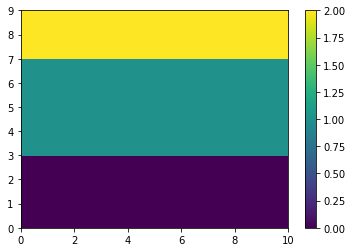

In [26]:
lithology = np.zeros((nz,ny,nx), dtype='int32')
lithology[:,3:7,:] = 1
lithology[:,7:,:]  = 2

plt.pcolor(lithology[5,:,:])
plt.colorbar()

In [27]:
def hofmeister1999(k0, T, a=0.25, c=0.0):
    return k0*(298.0/T)**a + c*T**3

def hofmeister1999_ad():
    pass

In [32]:
def forward_model(self, x, bc='Z'):
    k_list, H_list, a_list = np.array_split(x[:-1], 3)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    k = k0.copy()
    
    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    while error > tolerance:
        k_last = k.copy()
        self.mesh.diffusivity[:] = k
        T = self.linear_solve(rhs=rhs) # solve
        k = hofmeister1999(k0, T, a)
        error = np.absolute(k - k_last).max()
        i += 1
    print("{} iterations".format(i))
        
    q = self.heatflux(self.mesh.temperature[:], self.mesh.diffusivity[:])
    delT = self.gradient(T)
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T, delT=delT[0]) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    return cost

In [33]:
def adjoint_model(self, x, bc='Z'):
    k_list, H_list, a_list = np.array_split(x[:-1], 3)
    q0 = x[-1]
    
    # map to mesh
    k0, H, a = self.map(k_list, H_list, a_list)
    k = [k0.copy()]
    T = [None]
    
    self.mesh.update_properties(k0, H)
    self.mesh.boundary_condition("max"+bc, 298.0, flux=False)
    self.mesh.boundary_condition("min"+bc, q0, flux=True)
    rhs = self.mesh.construct_rhs()
    
    error = 10.
    tolerance = 1e-5
    i = 0
    self.mesh.temperature._gdata.set(0.)
    while error > tolerance:
        self.mesh.diffusivity[:] = k[i]
        # solve
        Ti = self.linear_solve(rhs=rhs)
        ki = hofmeister1999(k0, Ti, a)
        T.append(Ti.copy())
        k.append(ki.copy())
        error = np.absolute(k[-1] - k[-2]).max()
        i += 1
    print("{} iterations".format(i))

    q = self.heatflux(T[-1], k[-1])
    delT = self.gradient(T[-1])
    
    cost = 0.0
    cost += self.objective_routine(q=q[0], T=T[-1], delT=delT[0]) # observations
    cost += self.objective_routine(k=k_list, H=H_list, a=a_list, q0=q0) # priors
    
    ## AD ##
    dk = np.zeros_like(H)
    dH = np.zeros_like(H)
    dT = np.zeros_like(H)
    da = np.zeros_like(H)
    dk0 = np.zeros_like(H)
    dq0 = np.array(0.0)
    
    # priors
    dcdk_list = self.objective_routine_ad(k=k_list)
    dcdH_list = self.objective_routine_ad(H=H_list)
    dcda_list = self.objective_routine_ad(a=a_list)
    dcdq0 = self.objective_routine_ad(q0=q0)
    # observations
    dT += self.objective_routine_ad(T=T[-1])

    dq = np.zeros_like(q)
    dq[0] = self.objective_routine_ad(q=q[0])
    
    ddelT = np.zeros_like(delT)
    ddelT[0] = self.objective_routine_ad(delT=delT[0])
    

    dTd = self.gradient_ad(ddelT, T[-1])
    dT += dTd
    
    dTq, dkq = self.heatflux_ad(dq, q, T[-1], k[-1])
    dT += dTq
    dk += dkq
    

    # solve
    for j in xrange(i):
        dkda = np.log(298.0/T[-1-j])*k0*(298.0/T[-1-j])**a
        dkdk0 = (298.0/T[-1-j])**a
        dkdT = -a*k0/T[-1-j]*(298.0/T[-1-j])**a
        
        dk0 += dkdk0*dk
        dT  += dkdT*dk
        da  += dkda*dk
        
        dk.fill(0.0)
        

        self.mesh.diffusivity[:] = k[-1-j]
        dA, db = self.linear_solve_ad(T[-1-j], dT)

        dk += dA
        dH += -db
        dz = self.grid_delta[-1]
        lowerBC_mask = self.mesh.bc["min"+bc]["mask"]
        dq0 += np.sum(-db[lowerBC_mask]/dz/inv.ghost_weights[lowerBC_mask])
        
        dT.fill(0.0)
        
    dk0 += dk
        
    # pack to lists
    dk_list, dH_list, da_list = inv.map_ad(dk0, dH, da)
    dk_list += dcdk_list
    dH_list += dcdH_list
    da_list += dcda_list
    dq0 += dcdq0
    
    dx = np.hstack([dk_list, dH_list, da_list, [dq0]])
    
    return cost, dx

In [34]:
inv = InversionND(lithology.flatten(), mesh)

k = np.array([3.5, 2.0, 3.2])
H = np.array([0.1e-6, 1e-6, 2e-6])
a = np.array([0.25, 0.25, 0.25])*0.0
q0 = 35e-3

x = np.hstack([k, H, a, [q0]])
dx = x*0.01

# Priors
k_prior = k*1.1
H_prior = H*1.1
a_prior = a*1.1
q0_prior = np.array(30e-3)

sigma_k = k*0.1
sigma_H = H*0.1
sigma_a = a*0.1
sigma_q0 = np.array(5e-3)

In [35]:
from conduction.inversion import InvObservation, InvPrior

kp = InvPrior(k_prior, sigma_k)
Hp = InvPrior(H_prior, sigma_H)
ap = InvPrior(a_prior, sigma_a)
q0p = InvPrior(q0_prior, sigma_q0)

inv.add_prior(k=kp, H=Hp, q0=q0p)

fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference -0.9951
adjoint -1.06


In [36]:
inv = InversionND(lithology.flatten(), mesh)

ndelT = 50

delT = np.ones(ndelT)*1e3
sigma_delT = ndelT*0.001
delT_coord = np.zeros((ndelT,3))
delT_coord[:,0] = np.linspace(minX, maxX, ndelT)
delT_coord[:,1] = np.linspace(minY, maxY, ndelT)
delT_coord[:,2] = np.linspace(minZ, maxZ, ndelT)

delTobs = InvObservation(delT, sigma_delT, delT_coord)

inv.add_observation(delT=delTobs)

In [37]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference 0.00284194946289
adjoint 0.00300004643486


There is something wrong with the way dT is propogated!!

In [38]:
inv = InversionND(lithology.flatten(), mesh)

nqs = 500

qs = np.ones(nqs)*0.03
sigma_qs = qs*0.5
qs_coord = np.zeros((nqs,3))
qs_coord[:,0] = np.linspace(minX, maxX, nqs)
qs_coord[:,1] = np.linspace(minY, maxY, nqs)
qs_coord[:,2] = np.linspace(minZ, maxZ, nqs)


qobs = InvObservation(qs, sigma_qs, qs_coord)

inv.add_observation(q=qobs)

In [39]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference 57.7575028423
adjoint 57.1304359443


In [40]:
inv = InversionND(lithology.flatten(), mesh)

size = 50
cxy = np.empty((size,3))
cxy[:,0] = np.random.uniform(minX, maxX, size)
cxy[:,1] = np.random.uniform(minY, maxY, size)
cxy[:,2] = np.random.uniform(minZ, maxZ, size)

Tp = np.ones(size)*50
sigma_Tp = 0.1*Tp

Tobs = InvObservation(Tp, sigma_Tp, cxy)
inv.add_observation(T=Tobs)

In [41]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference 0.00548392545898
adjoint 0.00469355890073


In [42]:
inv = InversionND(lithology.flatten(), mesh)

Tp = np.ones(lithology.size)*50
sigma_Tp = 0.01*Tp

Tobs = InvObservation(Tp, sigma_Tp, mesh.coords)
inv.add_observation(T=Tobs)

In [43]:
fm0 = forward_model(inv, x)
fm1 = forward_model(inv, x+dx)
ad = adjoint_model(inv, x)

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference 9.76386904716
adjoint 8.7328524217


## 2D version

In [44]:
minX, maxX = 0.0, 1000.0
minY, maxY = -35e3, 1000.0
nx, ny = 10, 9
n = nx*ny

mesh = ConductionND((minX, minZ), (maxX, maxZ), (nx,ny))

# BCs
mesh.boundary_condition('maxY', 298.0, flux=False)
mesh.boundary_condition('minY', 0.04, flux=True)

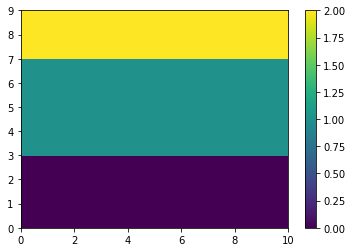

In [45]:
lithology = np.zeros((ny,nx), dtype='int32')
lithology[3:7,:] = 1
lithology[7:,:]  = 2

plt.pcolor(lithology)
plt.colorbar()

In [46]:
inv = InversionND(lithology.flatten(), mesh)

# inv.add_prior(k=kp, H=Hp, q0=q0p)

In [47]:
nqs = 500

qs = np.ones(nqs)*0.03
sigma_qs = qs*0.5
qs_coord = np.zeros((nqs,2))
qs_coord[:,0] = np.linspace(minX, maxX, nqs)
qs_coord[:,1] = 0.0
qs_coord[:,1] = np.linspace(minY, maxY, nqs)

qobs = InvObservation(qs, sigma_qs, qs_coord)

inv.add_observation(q=qobs)

In [48]:
fm0 = forward_model(inv, x, bc='Y')
fm1 = forward_model(inv, x+dx, bc='Y')
ad = adjoint_model(inv, x, bc='Y')

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference 35.7533566606
adjoint 35.2757785526


In [49]:
inv = InversionND(lithology.flatten(), mesh)

Tp = np.ones(lithology.size)*50
sigma_Tp = 0.01*Tp

Tobs = InvObservation(Tp, sigma_Tp, mesh.coords)
inv.add_observation(T=Tobs)

In [50]:
fm0 = forward_model(inv, x, bc='Y')
fm1 = forward_model(inv, x+dx, bc='Y')
ad = adjoint_model(inv, x, bc='Y')

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

1 iterations
1 iterations
1 iterations
finite difference -0.00146660208702
adjoint -0.00877203792334


In [51]:
import benpy
import conduction

minX, maxX, resX = -63250.0, 768632.0, 800
minY, maxY, resY = 5663750.0, 6227766.0, 550
minZ, maxZ, resZ = -52000.0, 2200.0, 260

Xcoords = np.linspace(minX, maxX, resX)
Ycoords = np.linspace(minY, maxY, resY)
Zcoords = np.linspace(minZ, maxZ, resZ)

file_dir = "/home/ben/git/python"
voxel = np.load(file_dir+'/data/victoria_model.npz')['data']


HFdata = benpy.heatFlowData(file_dir+'/data/HF_Jun-2015.csv')
thermalProperties = benpy.thermalProperties(file_dir+'/data/material_properties_condensed.csv')
# startProperties = benpy.thermalProperties(file_dir+'/data/inverted_material_properties.csv')



def find_nearest(array,value):
    return (np.abs(array-value)).argmin()

Ycut = find_nearest(Ycoords, 5966130.0)
Xcut = find_nearest(Xcoords, 417000)
Zcut = find_nearest(Zcoords, 0.0)

# Xcut, Ycut, Zcut = resX-1, resY-1, resZ-1
voxelSlice = voxel[:Zcut,Ycut,:Xcut] # nodata = -99999

# Reset boundaries
resX -= resX-Xcut
resZ -= resZ-Zcut
maxX = Xcoords[Xcut]
maxZ = Zcoords[Zcut]
Xcoords = np.linspace(minX, Xcoords[Xcut], resX)
Zcoords = np.linspace(minZ, Zcoords[Zcut], resZ)

xq, zq = np.meshgrid(Xcoords, Zcoords)
yq = np.zeros_like(xq) + Ycoords[Ycut]


# In[32]:

lithology_index = sorted(list(set(voxelSlice.flatten())))
size = len(lithology_index)

# parameters can't be too wild
bounds = {'k' : (0.5, 4.5),
          'H' : (0.0, 5e-6),
          'a' : (0.0, 1.0),
          'Q0': (10e-3, 45e-3)}

# Create bounds the same length as x
x_bounds = [bounds['k'],]*size
x_bounds.extend([bounds['H'],]*size)
x_bounds.extend([bounds['a'],]*size)
x_bounds.append(tuple(bounds['Q0']))
# x_bounds = [()] * (size*3+1)


k = np.zeros((size, 2))
H = np.zeros((size, 2))
a = np.zeros((size, 2))
x0 = np.zeros(size*3+1)

lithology = []
i = 0
for l, index in enumerate(thermalProperties.index):
    if index in lithology_index:
        lithology.append(thermalProperties.lithology[l])

        k[i,0] = thermalProperties.conductivity[l]
        k[i,1] = thermalProperties.conductivity_error[l]

        H[i,0] = thermalProperties.heatProduction[l]
        H[i,1] = thermalProperties.heatProduction_error[l]

        if lithology[i] in ['Magdala Volcanics', 'Stavely Volcanics']:
            a[i] = [0.25, 0.1/4]
            x0[i+2*size] = 0.25
        else:
            a[i] = [0.33, 0.1/4]
            x0[i+2*size] = 0.33

        if lithology[i] in 'Topography':
            x_bounds[i]      = (k[i,0], k[i,0])
            x_bounds[i+size] = (H[i,0], H[i,0])
            x_bounds[i+2*size] = (0.0, 0.0)
            a[i] = [0, 0.1]

        i += 1

q0 = 30e-3
sigma_q0 = 10e-3/4


# We want to convert lithology index to a range
voxelSlice2 = np.zeros_like(voxelSlice)
for i, lith in enumerate(lithology_index):
    mask = voxelSlice == lith
    voxelSlice2[mask] = i
voxelSlice = voxelSlice2


## Initialisation
radius = 10000.0 # distance from cross section

HFdata.trim(np.where(HFdata.eastings < Xcoords.min())[0])
HFdata.trim(np.where(HFdata.eastings > Xcoords.max())[0])

remove = []
for i, y in enumerate(HFdata.northings):
    if abs(y - Ycoords[Ycut]) > radius:
        remove.append(i)
HFdata.trim(remove)
HFdata.HF *= 1e-3
HFdata.HFerror *= 1e-3


# set up mesh
mesh = conduction.ConductionND((minX, minZ), (maxX, maxZ), (resX, resZ))
mesh.boundary_condition('maxY', 298.0, flux=False)
mesh.boundary_condition('minY', q0, flux=True)

# inv = benpy.Inversion(xq.flatten(), zq.flatten(), voxelSlice.flatten(), verbose=False, log=logfile)
inv = conduction.InversionND(voxelSlice.flatten(), mesh, pc='lu')

## Add priors
kp  = InvPrior(k[:,0], k[:,1])
Hp  = InvPrior(H[:,0], H[:,1])
ap  = InvPrior(a[:,0], a[:,1])
q0p = InvPrior(q0, sigma_q0)
# inv.add_prior(k=kp, H=Hp, a=ap, q0=q0p)

## Add observations
qxy = np.empty((HFdata.HF.size, 2))
qxy[:,0] = HFdata.eastings
qxy[:,1] = maxZ
qobs = InvObservation(HFdata.HF, HFdata.HFerror, qxy)
inv.add_observation(q=qobs)


# Starting x at priors
x0 = np.concatenate([k[:,0], H[:,0], a[:,0], [q0]])

In [52]:
x = x0
dx = 0.01*x

fm0 = forward_model(inv, x, 'Y')
fm1 = forward_model(inv, x+dx, 'Y')
ad = adjoint_model(inv, x, 'Y')

print "finite difference", (fm1 - fm0)
print "adjoint", ad[1].dot(dx)

7 iterations
7 iterations
7 iterations
finite difference 4.98476553345
adjoint 4.86173701344


In [ ]:
forward_model(inv, x, 'Y')

In [ ]:
temp = inv.mesh.temperature[:].reshape(inv.mesh.n)

In [ ]:
plt.imshow(temp, origin='lower')
plt.colorbar()

In [ ]:
hf = inv.heatflux(temp.ravel(), inv.mesh.diffusivity[:])
grad = inv.gradient(temp)
diff = inv.mesh.diffusivity[:]

In [ ]:
plt.imshow(diff.reshape(inv.mesh.n), origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(grad[0].reshape(inv.mesh.n), origin='lower')
plt.colorbar()

In [ ]:
plt.imshow(hf[0].reshape(inv.mesh.n), origin='lower')
plt.colorbar()

In [ ]:
hf[0][hf[0]!=0.0]